# Graphs and Code

github: https://github.com/terrablader11/bac-application

In [1]:
# @title
import pandas as pd
import matplotlib.pyplot as plt

url = "https://raw.githubusercontent.com/terrablader11/bac-application/main/yelp.csv"
df = pd.read_csv(url)

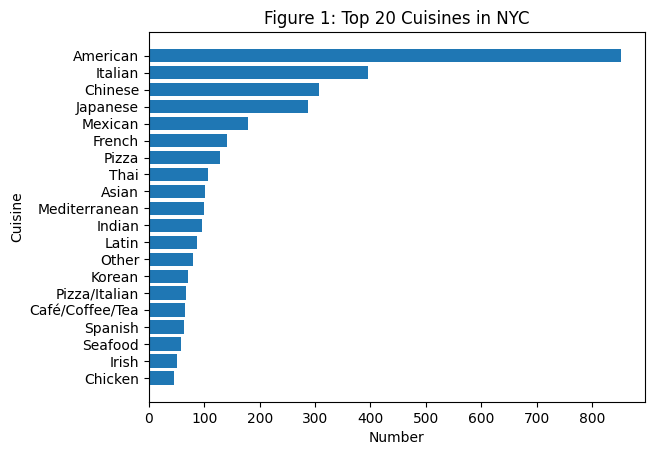

In [2]:
# @title
ser = df['CUISINE DESCRIPTION'].value_counts().iloc[0:20]
plt.barh(ser.keys(), ser)
plt.title("Figure 1: Top 20 Cuisines in NYC");
plt.xlabel("Number");
plt.ylabel("Cuisine");
plt.gca().invert_yaxis();

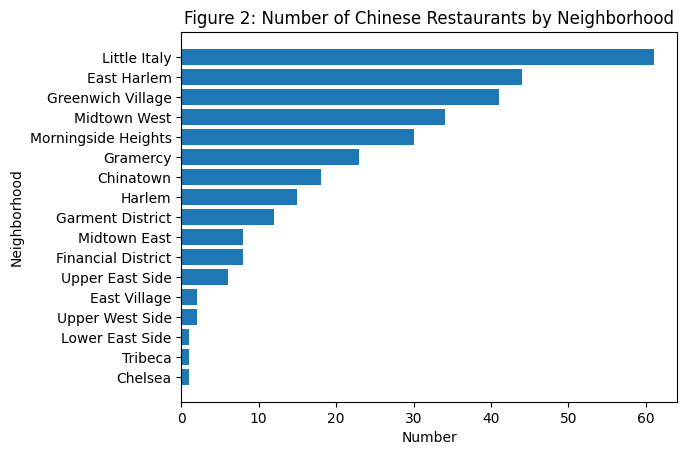

In [3]:
# @title
chinese_restaurants = df[df['CUISINE DESCRIPTION'] == "Chinese"].groupby(['neighborhood']).count().iloc[:, 0]
chinese_restaurants = chinese_restaurants.sort_values()
plt.barh(chinese_restaurants.keys(), chinese_restaurants)
plt.title("Figure 2: Number of Chinese Restaurants by Neighborhood");
plt.xlabel("Number");
plt.ylabel("Neighborhood");

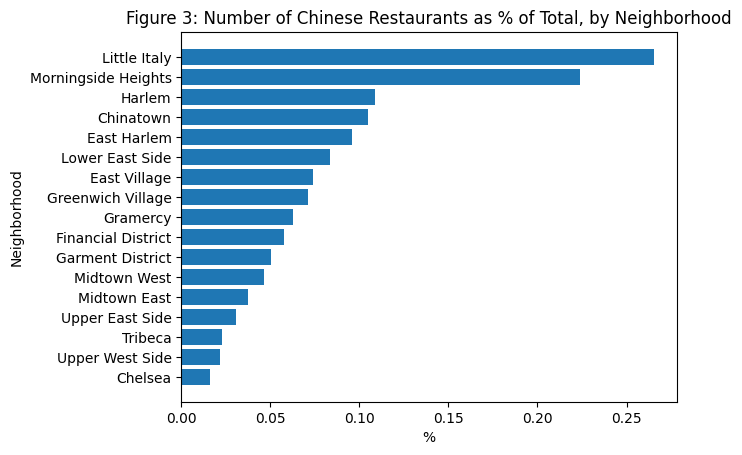

In [4]:
# @title
restaurants = df.groupby(['neighborhood']).count().iloc[:, 0]
percents = pd.DataFrame(chinese_restaurants).join(restaurants, lsuffix='_chinese', rsuffix='_total')
percents['%'] = percents['CAMIS_chinese'] / percents['CAMIS_total']
percents = percents.sort_values(by = ['%'])
plt.barh(percents.index, percents['%'])
plt.title("Figure 3: Number of Chinese Restaurants as % of Total, by Neighborhood");
plt.xlabel("%");
plt.ylabel("Neighborhood");

<Figure size 1000x1000 with 0 Axes>

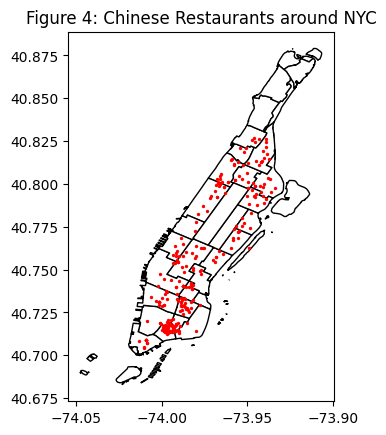

In [5]:
# @title
import geopandas as gpd
plotting = gpd.GeoDataFrame(df.loc[:, 'CUISINE DESCRIPTION'], geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
plotting = plotting[plotting['CUISINE DESCRIPTION'] == 'Chinese']


#from: https://data.cityofnewyork.us/City-Government/2010-Neighborhood-Tabulation-Areas-NTAs-/cpf4-rkhq
shapefile = gpd.read_file("/vsicurl/https://github.com/terrablader11/bac-application/raw/main/geo_export_1de8a75a-ec35-43a4-ad2a-9602ce6b6714.shp")
#remove all non-manhattan entries
shapefile = shapefile[shapefile['boro_name'] == "Manhattan"].reset_index(drop=True)
plt.figure(figsize=(10, 10))

base = shapefile.plot(color='white', edgecolor='black')
plt.title("Figure 4: Chinese Restaurants around NYC");
plotting.plot(ax=base, marker='o', markersize=2, color='red');

#lmao there is a chinese restaurant on roosevelt island??? must be fire i ought to try it

In [6]:
# @title
geography = gpd.GeoDataFrame(df.loc[:, ["CUISINE DESCRIPTION", "SCORE", "GRADE", "price", "rating", "review_count"]], geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
geography['district'] = ""

#assigns NYC preferred neighborhood name to each restaurant, and cleans up non-numeric data
for x in range(len(geography.iloc[:, 0])):
  if not geography.loc[x, "SCORE"].isnumeric() or geography.loc[x, "SCORE"] == "<NA>":
    geography.loc[x, "SCORE"] = 13

  geography.loc[x, "SCORE"] = int(geography.loc[x, "SCORE"])

  geography.loc[x, "price"] = len(str(geography.loc[x, "price"]))
  for y in range(len(shapefile.iloc[:, 0])):
    if geography.loc[x, "geometry"].within(shapefile.loc[y, "geometry"]):
      geography.loc[x, "district"] = shapefile.loc[y, "ntaname"]

<ipython-input-7-f8ee033bdb11>:2: FutureWarning: Dropping invalid columns in DataFrameGroupBy.mean is deprecated. In a future version, a TypeError will be raised. Before calling .mean, select only columns which should be valid for the function.
  geoexplore = gpd.GeoDataFrame(geography.groupby('district').mean(numeric_only=False).join(shapefile.set_index("ntaname").loc[:, "geometry"], lsuffix='_caller', rsuffix='_other'), geometry="geometry");


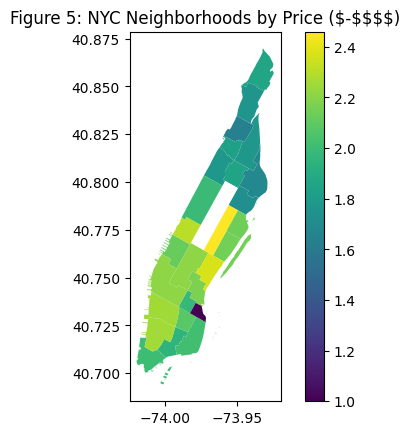

In [7]:
# @title
geoexplore = gpd.GeoDataFrame(geography.groupby('district').mean(numeric_only=False).join(shapefile.set_index("ntaname").loc[:, "geometry"], lsuffix='_caller', rsuffix='_other'), geometry="geometry");
geoexplore['SCORE'] = round(geoexplore['SCORE'], 2); geoexplore['price'] = round(geoexplore['price'], 2); geoexplore['rating'] = round(geoexplore['rating'], 2); geoexplore['review_count'] = round(geoexplore['review_count'], 2);

# FIGURE 5: Various Averages by NYC Neighborhood
geoexplore.plot(column='price', legend=True)
plt.title("Figure 5: NYC Neighborhoods by Price ($-$$$$)");

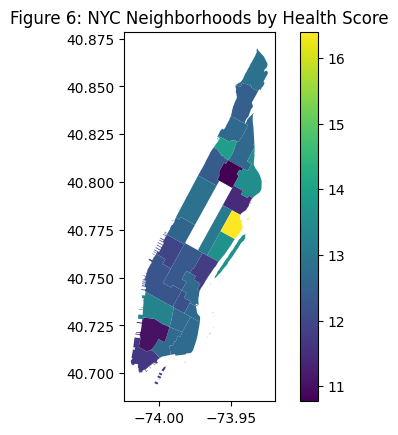

In [8]:
# @title
geoexplore.plot(column='SCORE', legend=True)
plt.title("Figure 6: NYC Neighborhoods by Health Score");

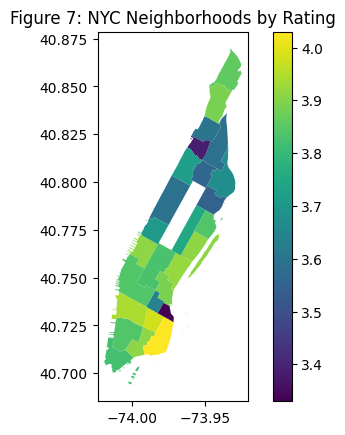

In [9]:
# @title
geoexplore.plot(column='rating', legend=True)
plt.title("Figure 7: NYC Neighborhoods by Rating");

<ipython-input-10-83d1a9948f85>:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  chinese_health_restaurants = copydf[copydf['CUISINE DESCRIPTION'] == "Chinese"].groupby(['neighborhood']).mean();


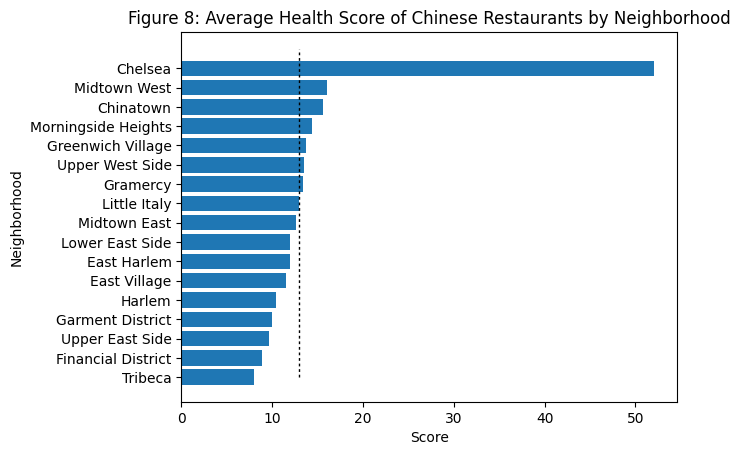

In [10]:
# @title
copydf = df.loc[:, ["CUISINE DESCRIPTION", "neighborhood", "SCORE"]]
for x in range(len(copydf.iloc[:, 0])):
  if not copydf.loc[x, "SCORE"].isnumeric():
    copydf.loc[x, "SCORE"] = pd.NA
  else:
    copydf.loc[x, "SCORE"] = int(copydf.loc[x, "SCORE"])



chinese_health_restaurants = copydf[copydf['CUISINE DESCRIPTION'] == "Chinese"].groupby(['neighborhood']).mean();
health_rating = chinese_health_restaurants.loc[:, "SCORE"].sort_values()
plt.barh(health_rating.index, health_rating);
plt.title("Figure 8: Average Health Score of Chinese Restaurants by Neighborhood")
plt.xlabel("Score");
plt.ylabel("Neighborhood");
#0-13 points: A https://a816-health.nyc.gov/ABCEatsRestaurants/#!/faq
plt.plot([13, 13], [0, 17], 'k-', lw=1,dashes=[2, 2])

#what are people doing in Chelsea???

In [11]:
# @title
#Appendix - Interactive Map
!pip install folium matplotlib mapclassify
geoexplore.explore()

In [12]:
# @title
geoexplore["score_rank"] = geoexplore['SCORE'].rank(ascending=False); geoexplore["price_rank"] = geoexplore["price"].rank(); geoexplore["rating_rank"] = geoexplore["rating"].rank()
geoexplore = geoexplore.join(gpd.GeoDataFrame(geography.groupby('district').count()).iloc[:, 0].rank().rename("density_rank"), lsuffix='_caller', rsuffix='_other')

geoexplore["total_rank"] = geoexplore["score_rank"] + geoexplore["price_rank"] + geoexplore["rating_rank"] + geoexplore["density_rank"]

# Appendix - Ranking List
geoexplore = geoexplore.loc[:, ["score_rank", "price_rank", "rating_rank", "density_rank", "total_rank"]].sort_values(by="total_rank")
geoexplore.iloc[0:10, :]

,score_rank,price_rank,rating_rank,density_rank,total_rank
district,,,,,
Manhattanville,2.0,8.0,2.0,3.0,15.0
Stuyvesant Town-Cooper Village,14.0,1.0,1.0,1.0,17.0
East Harlem North,4.0,3.0,9.0,11.0,27.0
Hamilton Heights,13.0,2.0,7.0,8.0,30.0
Central Harlem North-Polo Grounds,15.0,6.0,5.5,5.5,32.0
Washington Heights North,8.0,10.0,18.0,2.0,38.0
East Harlem South,25.0,4.0,3.0,9.0,41.0
Upper West Side,7.0,13.0,5.5,19.0,44.5
Central Harlem South,27.0,9.0,4.0,5.5,45.5
